In [1]:
%load_ext autoreload

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from utils.utils import show_images
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Callable
import os
import PIL.Image as Image
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from typing import Optional


In [3]:
manual_seed = 999
print(f"Random Seed: {manual_seed}")
random.seed(manual_seed)
torch.manual_seed(manual_seed)
# torch.use_deterministic_algorithms(True)

Random Seed: 999


In [4]:

latent_vector_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
%autoreload 2

from src.mod.plugins.early_stopping import EarlyStopping
from src.mod.datasets import CelebA
from src.mod.models import Classifier, Generator, Discriminator
from src.mod.datasets.utils import split_dataset


In [6]:
from typing import Mapping
from typing import Any
transform = transforms.Compose([
  transforms.Resize(64),
  transforms.CenterCrop(64),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='img_align_celeba',
  annotations_directory='annotations',
  image_transform=transform
)

generator = Generator(latent_vector_size, 64, 3, with_weights=torch.load('generator.pt'))
discriminator = Discriminator(3, 64, with_weights=torch.load('discriminator.pt'))
classifier = Classifier(64, 3)


In [7]:
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [9]:
classifier

Classifier(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

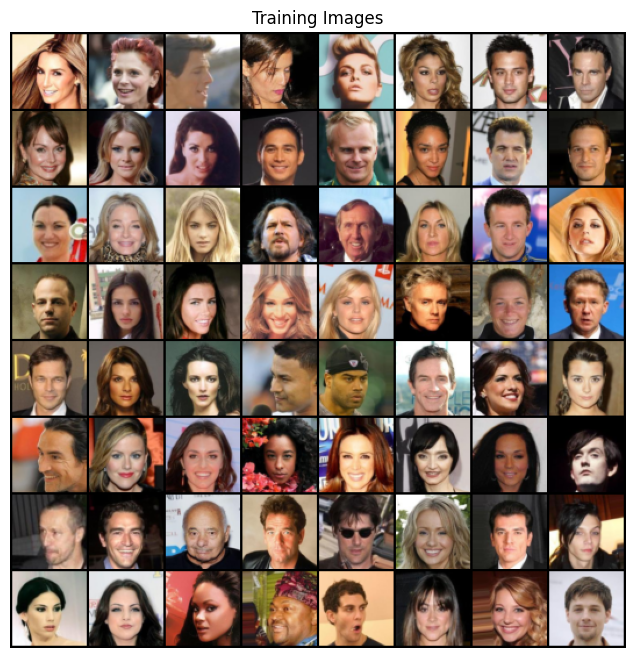

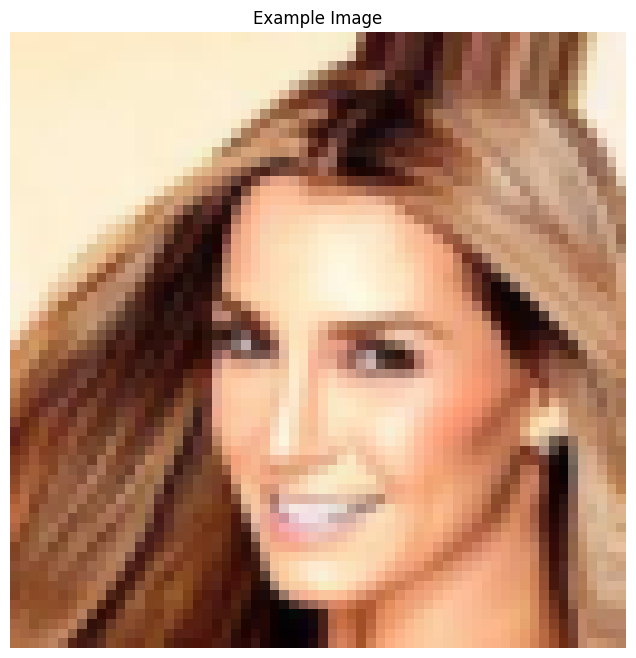

 1:  No - 5_o_Clock_Shadow
 2: Yes - Arched_Eyebrows
 3: Yes - Attractive
 4:  No - Bags_Under_Eyes
 5:  No - Bald
 6:  No - Bangs
 7:  No - Big_Lips
 8:  No - Big_Nose
 9:  No - Black_Hair
10:  No - Blond_Hair
11:  No - Blurry
12: Yes - Brown_Hair
13:  No - Bushy_Eyebrows
14:  No - Chubby
15:  No - Double_Chin
16:  No - Eyeglasses
17:  No - Goatee
18:  No - Gray_Hair
19: Yes - Heavy_Makeup
20: Yes - High_Cheekbones
21:  No - Male
22: Yes - Mouth_Slightly_Open
23:  No - Mustache
24:  No - Narrow_Eyes
25: Yes - No_Beard
26:  No - Oval_Face
27:  No - Pale_Skin
28: Yes - Pointy_Nose
29:  No - Receding_Hairline
30:  No - Rosy_Cheeks
31:  No - Sideburns
32: Yes - Smiling
33: Yes - Straight_Hair
34:  No - Wavy_Hair
35: Yes - Wearing_Earrings
36:  No - Wearing_Hat
37: Yes - Wearing_Lipstick
38:  No - Wearing_Necklace
39:  No - Wearing_Necktie
40: Yes - Young


In [10]:
def show_examples():
  dataloader = DataLoader(dataset, batch_size=64, num_workers=2)
  (images, _, _) = next(iter(dataloader))

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Training Images")
  show_images(images)

def show_annotated_example():
  dataloader = DataLoader(dataset, batch_size=1, num_workers=2)
  (images, annotations, _) = next(iter(dataloader))
  annotations = annotations[0][0]

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(images)
  for (i, column) in enumerate(dataset.annotations.columns):
    print(f"{i + 1:>2}: {annotations[i] > 0.9 and 'Yes' or 'No':>3} - {column}")

show_examples()
show_annotated_example()

Training Process:
1. GAN Training:
- Train D to differentiate real images from those generated by G.
- Train G to fool D into classifying its outputs as real images.
2. Classifier Training:
- Train C using real images and their trait annotations.
3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

In [11]:
from src.mod.datasets.utils import create_latent_vectors
from tqdm import tqdm
from torch.optim import AdamW

def train_gan(
    generator: nn.Module,
    discriminator: nn.Module,
    dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  generator.train()
  discriminator.train()
  generator.to(device)
  discriminator.to(device)

  RealLabel = 1.0
  FakeLabel = 0.0

  lr = 0.0002
  beta1 = 0.5

  discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
  discriminator_scheduler = ReduceLROnPlateau(discriminator_optimizer, 'min', patience=20, factor=0.5)
  generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  generator_scheduler = ReduceLROnPlateau(generator_optimizer, 'min', patience=20, factor=0.5)

  generator_criterion = nn.BCELoss()
  discriminator_criterion = nn.BCELoss()
  fixed_noise = create_latent_vectors(64, latent_vector_size, device)

  iterations = 0
  for epoch in tqdm(range(epoch_count), desc="Epochs", total=epoch_count):
    for batch_nr, (images, _, _) in tqdm(enumerate(dataloader), desc="Batches", total=len(dataloader)):
      discriminator.zero_grad()
      real_images = images.to(device)
      batch_size = real_images.size(0)

      real_labeling = torch.full((batch_size,), RealLabel, dtype=torch.float, device=device)
      expected_labeling = discriminator(real_images).view(-1)
      real_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      real_images_discriminator_loss.backward()

      latent_vectors = create_latent_vectors(batch_size, latent_vector_size, device)
      fake_images = generator(latent_vectors)
      real_labeling.fill_(FakeLabel)
      expected_labeling = discriminator(fake_images.detach()).view(-1)

      fake_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      fake_images_discriminator_loss.backward()

      discriminator_loss = real_images_discriminator_loss + fake_images_discriminator_loss
      discriminator_scheduler.step(discriminator_loss)

      generator.zero_grad()
      real_labeling.fill_(RealLabel)
      expected_labeling = discriminator(fake_images).view(-1)
      generator_loss = generator_criterion(expected_labeling, real_labeling)
      generator_loss.backward()
      generator_scheduler.step(generator_loss)

      if batch_nr % 50 == 0:
        dloss = discriminator_loss.item()
        gloss = generator_loss.item()
        print(f'[{epoch}/{epoch_count}][{batch_nr + 1}/{len(dataloader)}]', f"DLoss: {dloss:.4f}", f"Gloss: {gloss:.4f}")

      if (iterations % 500 == 0) or (((epoch % 5 == 0) or (epoch == epoch_count)) and (batch_nr == len(dataloader) - 1)):
        with torch.no_grad():
          fake_images = generator(fixed_noise).detach().cpu()
        show_images(fake_images)

      iterations += 1
  generator.eval()
  discriminator.eval()

  if save_to:
    torch.save(generator.state_dict(), f"g.{save_to}")
    torch.save(discriminator.state_dict(), f"d.{save_to}")

  return generator, discriminator

dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='img_align_celeba',
  annotations_directory='annotations',
  max_image_count=5000,
  image_transform=transform
)
dataloader = DataLoader(dataset, batch_size=64, num_workers=8)

generator = Generator(latent_vector_size, 64, 3, with_weights=torch.load('g.checkpoint.pt'))
discriminator = Discriminator(3, 64, with_weights=torch.load('d.checkpoint.pt'))

# train_gan(
#   generator,
#   discriminator,
#   dataloader,
#   epoch_count=20,
#   save_to="checkpoint.pt"
# )

2. Classifier Training:
- Train C using real images and their trait annotations.
3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

In [17]:
def train_classifier(
    classifier: nn.Module,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  classifier.train()
  classifier.to(device)

  lr = 0.0002
  beta1 = 0.5
  optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=(beta1, 0.999))
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
  epochs_without_improvement = 0
  criterion = nn.BCELoss()
  early_stopping = EarlyStopping(classifier, patience=10, verbose=True, save_to=save_to)

  for epoch in tqdm(range(1, epoch_count + 1), desc="Epochs", total=epoch_count):
    classifier.train()
    train_loss = 0.0
    for images, annotations, _ in tqdm(
        train_dataloader,
        desc="Traning",
        total=len(train_dataloader)
    ):
      classifier.zero_grad()
      real_images = images.to(device)
      annotations = annotations.to(device)
      expected_annotations = classifier(real_images).unsqueeze(1)

      real_images_loss = criterion(expected_annotations, annotations)
      real_images_loss.backward()

      optimizer.step()
      scheduler.step(real_images_loss)

      train_loss += real_images_loss.item()
    train_loss /= len(train_dataloader)

    classifier.eval()
    val_loss = 0.0
    for images, annotations, _ in tqdm(
        validation_dataloader,
        desc="Validation",
        total=len(validation_dataloader)
    ):
      classifier.zero_grad()
      real_images = images.to(device)
      annotations = annotations.to(device)
      expected_annotations = classifier(real_images).unsqueeze(1)
      real_images_loss = criterion(expected_annotations, annotations)
      val_loss += real_images_loss.item()
      optimizer.step()
      scheduler.step(real_images_loss)

    val_loss /= len(validation_dataloader)

    if early_stopping.step(val_loss): break

  classifier.load_state_dict(save_to)

  return classifier

from typing import Optional, Mapping, Any

import numpy as np
from torch import nn, Tensor

def initialize_weights(layer: nn.Module):
  if isinstance(layer, nn.Linear):
    nn.init.xavier_uniform_(layer.weight.data)
    if layer.bias is not None:
      nn.init.constant_(layer.bias.data, 0)

from typing import Optional, Mapping, Any

import numpy as np
from torch import nn, Tensor


train_dataloader, validation_dataloader = split_dataset(dataset, 0.8)
classifier = Classifier((3, 64, 64), 40, with_weights=torch.load('c.checkpoint.pt'))

# train_classifier(
#   classifier,
#   train_dataloader,
#   validation_dataloader,
#   epoch_count=20,
#   save_to="checkpoint.pt"
# )


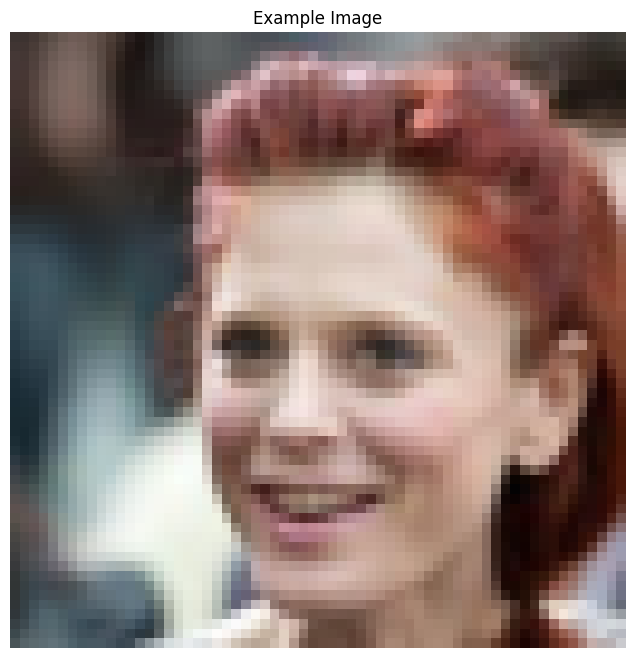

 0:  No - C0.16 - E0.16 - 5_o_Clock_Shadow
 1:  No - C0.27 - E0.27 - Arched_Eyebrows
 2:  No - C0.56 - E0.56 - Attractive
 3: Yes - C0.24 - E0.76 - Bags_Under_Eyes
 4:  No - C0.04 - E0.04 - Bald
 5:  No - C0.18 - E0.18 - Bangs
 6:  No - C0.17 - E0.17 - Big_Lips
 7: Yes - C0.16 - E0.84 - Big_Nose
 8:  No - C0.14 - E0.14 - Black_Hair
 9:  No - C0.16 - E0.16 - Blond_Hair
10:  No - C0.04 - E0.04 - Blurry
11: Yes - C0.14 - E0.86 - Brown_Hair
12:  No - C0.23 - E0.23 - Bushy_Eyebrows
13:  No - C0.07 - E0.07 - Chubby
14:  No - C0.03 - E0.03 - Double_Chin
15:  No - C0.08 - E0.08 - Eyeglasses
16:  No - C0.08 - E0.08 - Goatee
17:  No - C0.06 - E0.06 - Gray_Hair
18:  No - C0.34 - E0.34 - Heavy_Makeup
19: Yes - C0.41 - E0.59 - High_Cheekbones
20:  No - C0.48 - E0.48 - Male
21: Yes - C0.44 - E0.56 - Mouth_Slightly_Open
22:  No - C0.07 - E0.07 - Mustache
23:  No - C0.15 - E0.15 - Narrow_Eyes
24: Yes - C0.79 - E0.21 - No_Beard
25:  No - C0.28 - E0.28 - Oval_Face
26:  No - C0.12 - E0.12 - Pale_Skin
27:

In [38]:
# Test classifier on real images and show real image and predicted attributes

def show_real_image_and_predicted_attributes(classifier, dataset, index):
  (image, attributes, _) = dataset[index]
  image = image.unsqueeze(0)
  attributes = attributes.unsqueeze(0).numpy()
  classified = classifier(image).cpu().detach().numpy()
  errors = np.abs(classified - attributes)

  attributes = attributes[0][0]
  classified = classified[0]
  errors = errors[0][0]

  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(image)
  for i, (attribute, classification, error, label) in enumerate(
      zip(attributes, classified, errors, dataset.annotations.columns)
  ):
    print(f"{i:>2}: {attribute > 0.9 and 'Yes' or 'No':>3} - C{classification:.2f} - E{error:.2f} - {label}")

show_real_image_and_predicted_attributes(classifier, dataset, 1)


3. Combined Training:
- Train G to not only fool D but also to generate images that C classifies with specified traits.

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

[0/20][1/79] DLoss: 3.4199 Gloss: 0.0541 Closs: 0.4464


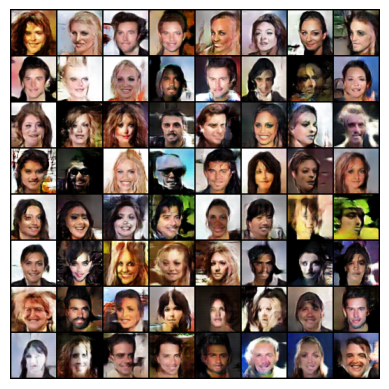


Batches:  70%|██████▉   | 55/79 [00:05<00:01, 15.21it/s]

[0/20][51/79] DLoss: 2.9328 Gloss: 0.0869 Closs: 0.4285



Batches:  97%|█████████▋| 77/79 [00:06<00:00, 16.00it/s]

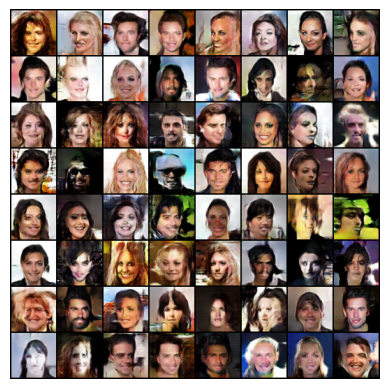

Batches:   5%|▌         | 4/79 [00:00<00:11,  6.54it/s]

[1/20][1/79] DLoss: 2.8034 Gloss: 0.1086 Closs: 0.4345



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.81it/s]

[1/20][51/79] DLoss: 3.2547 Gloss: 0.0720 Closs: 0.4314



Batches:   5%|▌         | 4/79 [00:00<00:10,  7.07it/s]

[2/20][1/79] DLoss: 3.1685 Gloss: 0.0694 Closs: 0.4356



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 13.53it/s]

[2/20][51/79] DLoss: 2.9567 Gloss: 0.0933 Closs: 0.4341



Batches:   5%|▌         | 4/79 [00:00<00:11,  6.26it/s]

[3/20][1/79] DLoss: 3.0929 Gloss: 0.0798 Closs: 0.4383



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.78it/s]

[3/20][51/79] DLoss: 3.0669 Gloss: 0.0852 Closs: 0.4289



Batches:   5%|▌         | 4/79 [00:00<00:10,  7.27it/s]

[4/20][1/79] DLoss: 2.9880 Gloss: 0.0751 Closs: 0.4383



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.39it/s]

[4/20][51/79] DLoss: 3.2602 Gloss: 0.0660 Closs: 0.4255



Batches:   5%|▌         | 4/79 [00:00<00:11,  6.46it/s]

[5/20][1/79] DLoss: 3.3044 Gloss: 0.0713 Closs: 0.4460



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.76it/s]

[5/20][51/79] DLoss: 3.3377 Gloss: 0.0664 Closs: 0.4276



Batches:  96%|█████████▌| 76/79 [00:06<00:00, 14.22it/s]

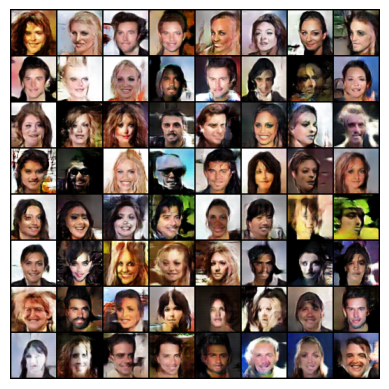


Batches:   5%|▌         | 4/79 [00:00<00:10,  7.20it/s]

[6/20][1/79] DLoss: 3.1713 Gloss: 0.0767 Closs: 0.4428



Batches:  32%|███▏      | 25/79 [00:02<00:05, 10.67it/s]

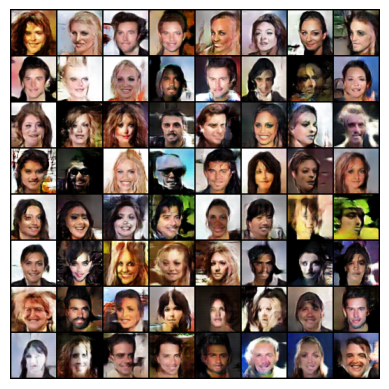


Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.29it/s]

[6/20][51/79] DLoss: 3.2944 Gloss: 0.0688 Closs: 0.4314



Batches:   5%|▌         | 4/79 [00:00<00:10,  7.09it/s]

[7/20][1/79] DLoss: 3.1487 Gloss: 0.0792 Closs: 0.4417



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.10it/s]

[7/20][51/79] DLoss: 2.9932 Gloss: 0.0979 Closs: 0.4221



Batches:   5%|▌         | 4/79 [00:00<00:11,  6.60it/s]

[8/20][1/79] DLoss: 3.2144 Gloss: 0.0656 Closs: 0.4393



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.44it/s]

[8/20][51/79] DLoss: 2.9962 Gloss: 0.0924 Closs: 0.4359



Batches:   5%|▌         | 4/79 [00:00<00:10,  6.83it/s]

[9/20][1/79] DLoss: 3.2570 Gloss: 0.0629 Closs: 0.4358



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.68it/s]

[9/20][51/79] DLoss: 3.3311 Gloss: 0.0644 Closs: 0.4372



Batches:   5%|▌         | 4/79 [00:00<00:11,  6.68it/s]

[10/20][1/79] DLoss: 3.0565 Gloss: 0.0685 Closs: 0.4421



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 14.64it/s]

[10/20][51/79] DLoss: 3.3597 Gloss: 0.0710 Closs: 0.4237



Batches:  96%|█████████▌| 76/79 [00:06<00:00, 12.74it/s]

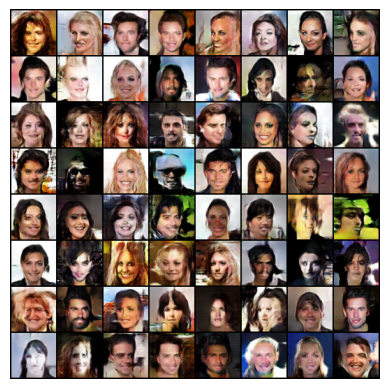


Batches:   5%|▌         | 4/79 [00:00<00:11,  6.25it/s]

[11/20][1/79] DLoss: 3.2642 Gloss: 0.0699 Closs: 0.4308



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.12it/s]

[11/20][51/79] DLoss: 3.4037 Gloss: 0.0587 Closs: 0.4384



Batches:   5%|▌         | 4/79 [00:00<00:10,  7.19it/s]

[12/20][1/79] DLoss: 3.5589 Gloss: 0.0496 Closs: 0.4431



Batches:  65%|██████▍   | 51/79 [00:04<00:02, 12.39it/s]

[12/20][51/79] DLoss: 3.3375 Gloss: 0.0612 Closs: 0.4238


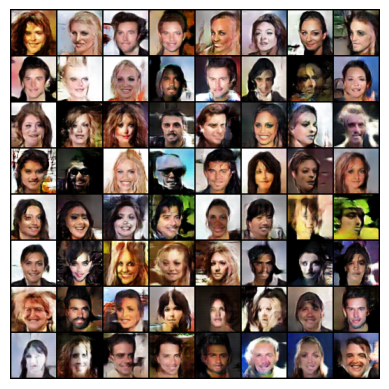


Batches:   5%|▌         | 4/79 [00:00<00:11,  6.73it/s]

[13/20][1/79] DLoss: 2.6878 Gloss: 0.1259 Closs: 0.4365



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.15it/s]

[13/20][51/79] DLoss: 3.2896 Gloss: 0.0684 Closs: 0.4256



Batches:   5%|▌         | 4/79 [00:00<00:12,  6.10it/s]

[14/20][1/79] DLoss: 3.1930 Gloss: 0.0834 Closs: 0.4246



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 13.98it/s]

[14/20][51/79] DLoss: 2.8649 Gloss: 0.0871 Closs: 0.4296



Batches:   5%|▌         | 4/79 [00:00<00:10,  7.01it/s]

[15/20][1/79] DLoss: 2.9347 Gloss: 0.0976 Closs: 0.4407



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.44it/s]

[15/20][51/79] DLoss: 3.1823 Gloss: 0.0667 Closs: 0.4233



Batches:  99%|█████████▊| 78/79 [00:05<00:00, 16.53it/s]

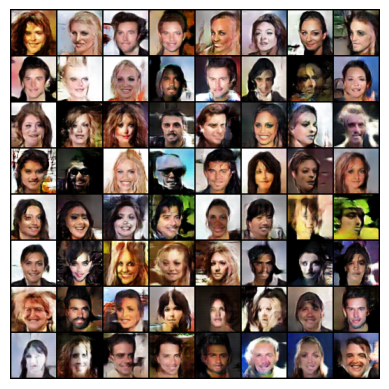

Batches:   5%|▌         | 4/79 [00:00<00:10,  6.93it/s]

[16/20][1/79] DLoss: 3.1865 Gloss: 0.0709 Closs: 0.4348



Batches:  68%|██████▊   | 54/79 [00:04<00:01, 14.00it/s]

[16/20][51/79] DLoss: 2.7056 Gloss: 0.1258 Closs: 0.4305



Batches:   5%|▌         | 4/79 [00:00<00:11,  6.36it/s]

[17/20][1/79] DLoss: 3.3468 Gloss: 0.0776 Closs: 0.4355



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.71it/s]

[17/20][51/79] DLoss: 2.6910 Gloss: 0.1270 Closs: 0.4302



Batches:   5%|▌         | 4/79 [00:00<00:10,  6.82it/s]

[18/20][1/79] DLoss: 3.1096 Gloss: 0.0797 Closs: 0.4349



Batches:  71%|███████   | 56/79 [00:04<00:01, 16.48it/s]

[18/20][51/79] DLoss: 3.0958 Gloss: 0.0770 Closs: 0.4350



Batches:  97%|█████████▋| 77/79 [00:06<00:00, 15.76it/s]

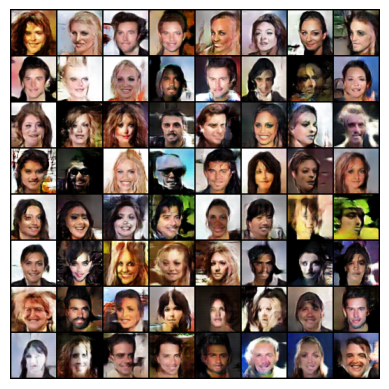

Batches:   5%|▌         | 4/79 [00:00<00:10,  7.05it/s]

[19/20][1/79] DLoss: 3.0339 Gloss: 0.0881 Closs: 0.4423



Batches:  70%|██████▉   | 55/79 [00:04<00:01, 15.55it/s]

[19/20][51/79] DLoss: 3.0366 Gloss: 0.0857 Closs: 0.4314



Batches:  96%|█████████▌| 76/79 [00:05<00:00, 14.94it/s]

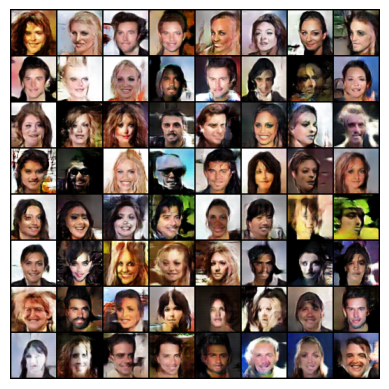


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.50s/it]


(Generator(
   (main): Sequential(
     (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
     (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): ReLU(inplace=True)
     (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (13

In [46]:
def train_gan_and_classifier_at_the_same_time(
    generator: nn.Module,
    discriminator: nn.Module,
    classifier: nn.Module,
    dataloader: DataLoader,
    *,
    epoch_count: int,
    save_to: Optional[str] = None,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
  generator.train()
  discriminator.train()
  classifier.train()
  generator.to(device)
  discriminator.to(device)
  classifier.to(device)

  RealLabel = 1.0
  FakeLabel = 0.0

  lr = 0.0002
  beta1 = 0.5

  discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
  discriminator_scheduler = ReduceLROnPlateau(discriminator_optimizer, 'min', patience=20, factor=0.5)
  generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  generator_scheduler = ReduceLROnPlateau(generator_optimizer, 'min', patience=20, factor=0.5)
  classifier_optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=(beta1, 0.999))
  classifier_scheduler = ReduceLROnPlateau(classifier_optimizer, 'min', patience=20, factor=0.5)

  generator_criterion = nn.BCELoss()
  discriminator_criterion = nn.BCELoss()
  classifier_criterion = nn.BCELoss()
  fixed_noise = create_latent_vectors(64, latent_vector_size, device)

  iterations = 0
  for epoch in tqdm(range(epoch_count), desc="Epochs", total=epoch_count):
    for batch_nr, (images, annotations, _) in tqdm(enumerate(dataloader), desc="Batches", total=len(dataloader)):
      real_images = images.to(device)
      annotations = annotations.to(device)

      batch_size = real_images.size(0)
      real_labeling = torch.full((batch_size,), RealLabel, dtype=torch.float, device=device)

      discriminator.zero_grad()
      expected_labeling = discriminator(real_images).view(-1)
      real_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      real_images_discriminator_loss.backward()

      latent_vectors = create_latent_vectors(batch_size, latent_vector_size, device)
      fake_images = generator(latent_vectors).detach()
      real_labeling.fill_(FakeLabel)
      expected_labeling = discriminator(fake_images).view(-1)
      fake_images_discriminator_loss = discriminator_criterion(expected_labeling, real_labeling)
      fake_images_discriminator_loss.backward()

      discriminator_loss = real_images_discriminator_loss + fake_images_discriminator_loss
      discriminator_scheduler.step(discriminator_loss)

      generator.zero_grad()
      real_labeling.fill_(RealLabel)
      fake_images = generator(latent_vectors).detach()
      expected_labeling = discriminator(fake_images).view(-1)
      generator_loss = generator_criterion(expected_labeling, real_labeling)
      generator_loss.backward()
      generator_scheduler.step(generator_loss)

      classifier.zero_grad()
      expected_annotations = classifier(fake_images).unsqueeze(1)
      classifier_loss = classifier_criterion(expected_annotations, annotations)
      classifier_loss.backward()
      classifier_scheduler.step(classifier_loss)

      if batch_nr % 50 == 0:
        dloss = discriminator_loss.item()
        gloss = generator_loss.item()
        closs = classifier_loss.item()

        print(
          f'[{epoch}/{epoch_count}][{batch_nr + 1}/{len(dataloader)}]',
          f"DLoss: {dloss:.4f}",
          f"Gloss: {gloss:.4f}",
          f"Closs: {closs:.4f}"
        )

      if (iterations % 500 == 0) or (((epoch % 5 == 0) or (epoch == epoch_count - 1)) and (batch_nr == len(dataloader) - 1)):
        with torch.no_grad():
          fake_images = generator(fixed_noise).detach().cpu()
        show_images(fake_images)
      iterations += 1

  generator.eval()
  discriminator.eval()
  classifier.eval()

  if save_to:
    torch.save(generator.state_dict(), f"g.{save_to}")
    torch.save(discriminator.state_dict(), f"d.{save_to}")
    torch.save(classifier.state_dict(), f"c.{save_to}")

  return generator, discriminator, classifier


dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='img_align_celeba',
  annotations_directory='annotations',
  max_image_count=5000,
  image_transform=transform
)

dataloader = DataLoader(dataset, batch_size=64, num_workers=8)

generator = Generator(latent_vector_size, 64, 3, with_weights=torch.load('g.checkpoint.pt'))
discriminator = Discriminator(3, 64, with_weights=torch.load('d.checkpoint.pt'))
classifier = Classifier((3, 64, 64), 40, with_weights=torch.load('c.checkpoint.pt'))

train_gan_and_classifier_at_the_same_time(
  generator,
  discriminator,
  classifier,
  dataloader,
  epoch_count=20,
  save_to="run_three.pt"
)

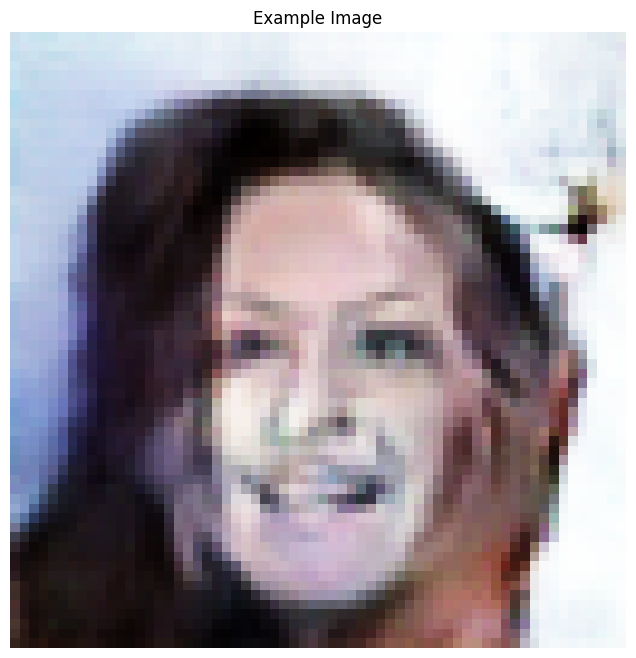

 1:  No - 0.06 -  5_o_Clock_Shadow
 2:  No - 0.34 -  Arched_Eyebrows
 3: Yes - 0.70 -  Attractive
 4:  No - 0.14 -  Bags_Under_Eyes
 5:  No - 0.02 -  Bald
 6:  No - 0.14 -  Bangs
 7:  No - 0.21 -  Big_Lips
 8:  No - 0.15 -  Big_Nose
 9:  No - 0.19 -  Black_Hair
10:  No - 0.13 -  Blond_Hair
11:  No - 0.03 -  Blurry
12:  No - 0.19 -  Brown_Hair
13:  No - 0.09 -  Bushy_Eyebrows
14:  No - 0.03 -  Chubby
15:  No - 0.03 -  Double_Chin
16:  No - 0.03 -  Eyeglasses
17:  No - 0.04 -  Goatee
18:  No - 0.04 -  Gray_Hair
19: Yes - 0.52 -  Heavy_Makeup
20: Yes - 0.53 -  High_Cheekbones
21:  No - 0.29 -  Male
22: Yes - 0.52 -  Mouth_Slightly_Open
23:  No - 0.02 -  Mustache
24:  No - 0.09 -  Narrow_Eyes
25: Yes - 0.89 -  No_Beard
26:  No - 0.28 -  Oval_Face
27:  No - 0.04 -  Pale_Skin
28:  No - 0.22 -  Pointy_Nose
29:  No - 0.05 -  Receding_Hairline
30:  No - 0.06 -  Rosy_Cheeks
31:  No - 0.03 -  Sideburns
32: Yes - 0.50 -  Smiling
33:  No - 0.21 -  Straight_Hair
34:  No - 0.37 -  Wavy_Hair
35:  No -

In [68]:
vec = create_latent_vectors(1, latent_vector_size, device)
generated = generator(vec)
annotations = classifier(generated).cpu().detach().numpy()[0]

def show_annotated_image(image, annotations):
  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.title("Example Image")
  show_images(image)
  for (i, column) in enumerate(dataset.annotations.columns):
    print(f"{i + 1:>2}: {annotations[i] > 0.4 and 'Yes' or 'No':>3} - {annotations[i]:.2f} -  {column}")

show_annotated_image(generated, annotations)

# 4. Latent Vector Generation and Manipulation

In [278]:
class LatentSpaceManipulator:
  def __init__(self, generator: nn.Module, classifier: nn.Module, device: torch.device):
    self.generator = generator
    self.classifier = classifier
    self.device = device

  def manipulate(self, latent_vector, target_traits, alpha=0.01, steps=100):
    self.generator.to(self.device)
    self.classifier.to(self.device)
    latent_vector = latent_vector.clone().detach().requires_grad_(True)
    latent_vector.to(self.device)
    target_traits.to(self.device)

    vectors = [latent_vector.clone()]
    for _ in range(steps):
      generated_image = self.generator(latent_vector)
      predicted_traits = self.classifier(generated_image)
      loss = ((predicted_traits - target_traits) ** 2).mean()
      loss.backward()

      with torch.no_grad():
        latent_vector -= alpha * latent_vector.grad
      latent_vector.grad.zero_()
      vectors.append(latent_vector.clone())

    return latent_vector, vectors
manipulator = LatentSpaceManipulator(generator, classifier, device)
  

In [245]:


manipulator = LatentSpaceManipulator(generator, classifier, device)
generator = Generator(latent_vector_size, 64, 3, with_weights=torch.load('g.run_three.pt'))
classifier = Classifier((3, 64, 64), 40, with_weights=torch.load('c.run_three.pt'))
latent_vector = create_latent_vectors(1, latent_vector_size, device)

target_annotations = torch.zeros(40, device=device)
target_annotations[-1] = 100

generator.to(device)
classifier.to(device)

classification = classifier(generator(latent_vector))

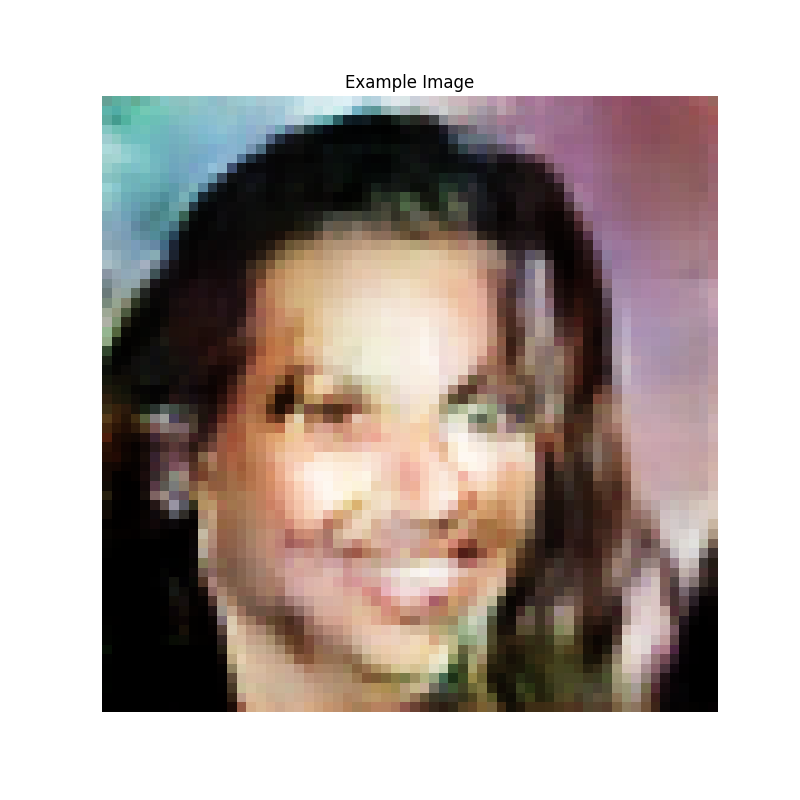

In [246]:
show_images(generator(latent_vector))

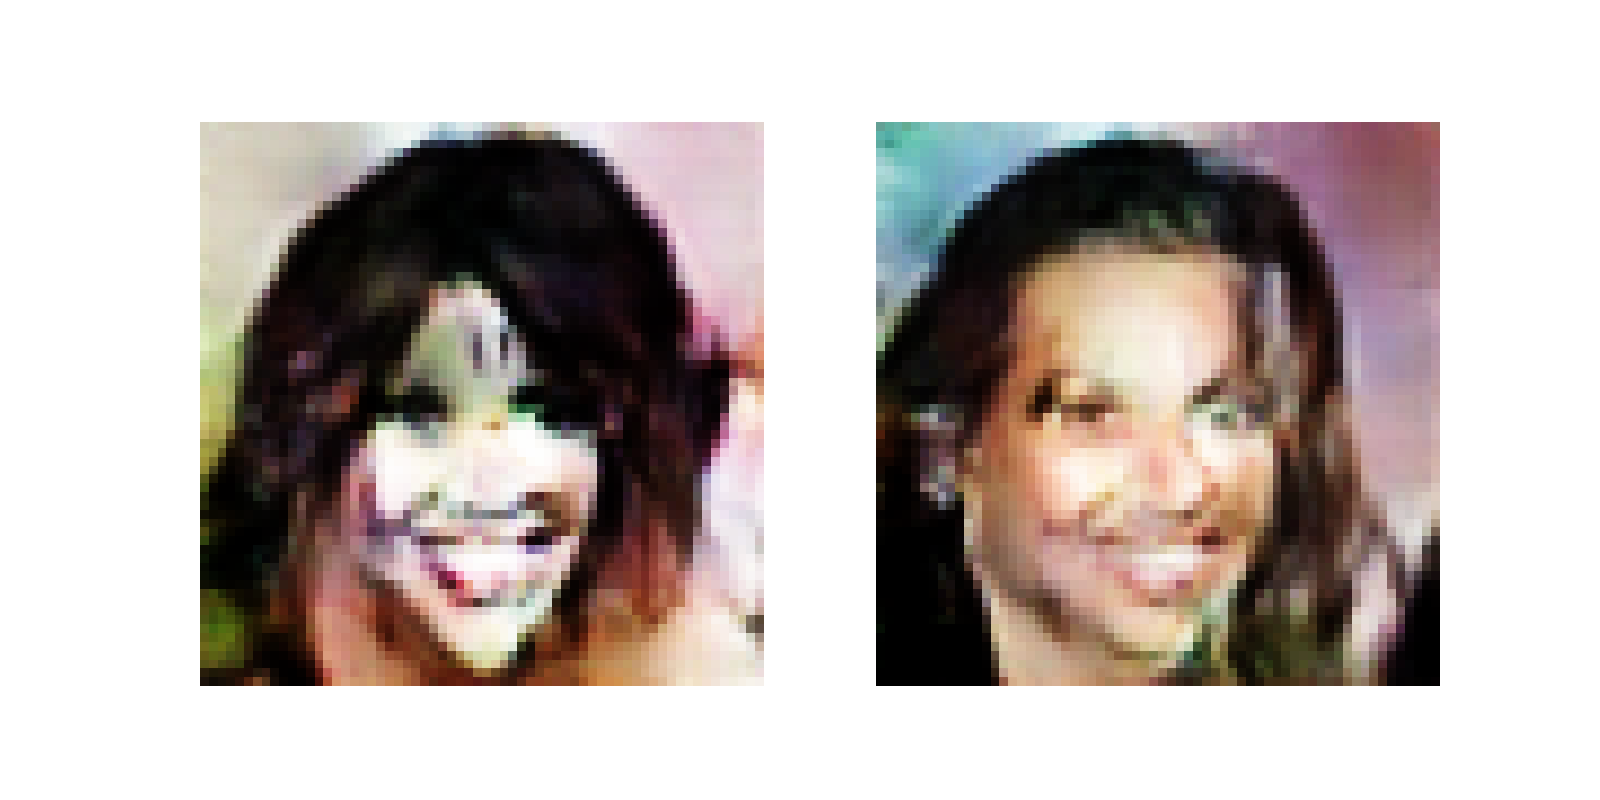

In [300]:
altered = latent_vector.clone().detach().requires_grad_(True)
altered.to(device)

target_annotations = torch.zeros(40, device=device)
target_annotations[-1] = 100

altered_vector, history = manipulator.manipulate(altered, target_annotations, alpha=0.5, steps=1000)

show_images(generator(altered_vector), generator(latent_vector))


In [295]:
# import interactive
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib widget

images = []
generator.to(device)
for v in history:
  images.append(generator(v).cpu().detach().numpy().squeeze().transpose(1, 2, 0))
  

interactive(children=(IntSlider(value=500, description='index', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.show_image(index)>

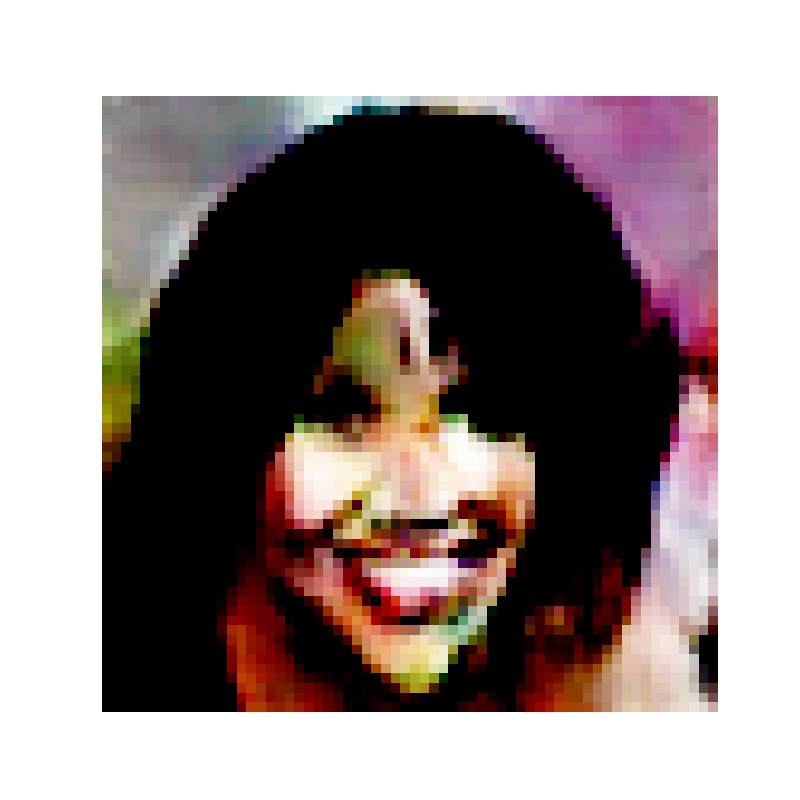

In [296]:

def show_image(index):
  plt.figure(figsize=(8, 8))
  plt.axis("off")
  plt.imshow(images[index])
  
interact(show_image, index=(0, len(images) - 1, 1))
